# Image classification
We build a neural network for image classification. We use a dataset of small RGB images classified into 10 categories labeled from 0 to 9. Since we will train a dataset of 10000 images it is suggested to use a GPU.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch

## The CIFAR10 dataset
CIFAR10 is a dataset of 50000 small RGB images of 32x32 pixels classified in 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The dataset can be downloaded using the datasets PyTorch module. 

In [ ]:
from torchvision import datasets
data_path = 'data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data-unversioned/p1ch7/cifar-10-python.tar.gz to data-unversioned/p1ch7/
Files already downloaded and verified


In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

The dataset is composed of 50000 images

In [ ]:
len(cifar10)

50000

In [ ]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FA75E0CC990>,
 1,
 'automobile')

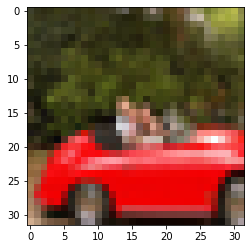

In [ ]:
plt.imshow(img)

We have to transform images into PyTorch tensors. PyTorch provides many transformations

In [ ]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

We use the ToTensor() transformation to transform a PIL image into a PyTorch tensor- In our case the tensor is a 3D array of 3 channels, 32 rows (height) and 32 columns (width)

In [ ]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

We can transform all the images in the dataset to tensor by passing the transform function

In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

Any element of the dataset is now a tensor

In [ ]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [ ]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Values in the tensor range from 0 to 1

In [ ]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

We can draw the image from the tensor by permuting the dimensions from (Channel x Height x Width) into (Height x Width x Channel) that is from (0, 1, 2) to (1, 2, 0)

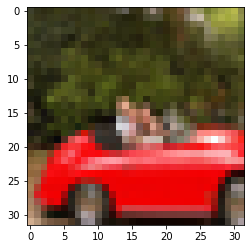

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

We want to normalize the values in the images. We can apply a transformation to all the images. In order to do that we build a batch from the CIFAR10 dataset by stacking all of them in a 4 dimensional tensor.

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

Now we can compute the mean for each channel

In [ ]:
mean = imgs.view(3, -1).mean(dim=1)
mean

tensor([0.4914, 0.4822, 0.4465])

and the standard deviation

In [ ]:
std = imgs.view(3, -1).std(dim=1)
std

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
transforms.Normalize(mean, std)

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

We apply the transformations to tensor and normalization in sequence

In [ ]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [ ]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

If we try to visualize a tensor as an image after the normalization the result will be different from what we had before

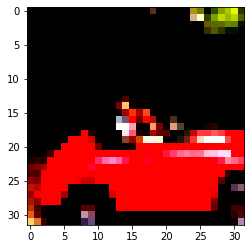

In [ ]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Building a classifier
We want to build a classifier that can tell whether an image contains an airplane or a bird. We don't know any rule to make such distiction so we use a neural network to be trained using images of airplanes and birds. We can use a subset of the CIFAR10 dataset filtering out all the images that are not airplanes or birds. We use two Python list comprehensions to create the dataset for airplanes and birds

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]
len(cifar2), len(cifar2_val)

(10000, 2000)

We build a simple neural network with one input layer, one hidden layer with an activation function for the non-linearity, and the final output layer. Since the images have three channels of size 32x32 we need an input layer of 3x32x32=3072 units. We choose to connect each input unit to 512 units in the hidden layer and each of these to 2 output units to tell whether an image contains an airplane or a bird. The output of the units in the hidden layer is given by a linear transformation of the inputs followed by the application of an activation function. 

$$y = \sigma(\hat{W}\vec{x} + \vec{b})$$

where $\hat{W}$ is the 3x32x32x512 = 1.572.864 weights matrix that connects any unit of the input layer to any unit of the hidden layer, $\vec{b}$ is the bias vector, and $\sigma$ is the activation function computed at each unit of the hidden layer. The same holds also for the output layer.

In [ ]:
import torch.nn as nn
num_input_units = 3072
num_hidden_units = 512
n_out = 2

model = nn.Sequential(
            nn.Linear(num_input_units, num_hidden_units),
            nn.Tanh(),
            nn.Linear(num_hidden_units, n_out)
        )

We interpret the values returned from the output units as probabilities for an image to contain an airplane of a bird. In order to tell the class we need a function that takes two values from the output units and returns two probabilities in the interval [0, 1] whose sum is 1.0. If the first value is higher than 0.5 the image contains an airplane with that value as its probability. We use the softmax function $\sigma(x)$ to map the values of the output units to probabilities

$$\sigma(x_i) = \frac{e^{x_i}}{\sum_{j = 1}^N e^{x_j}}$$

where in our case N = 2. we can define the function and see how it works

In [ ]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0])
s = softmax(x)
s

tensor([0.0900, 0.2447, 0.6652])

In [ ]:
s.sum()

tensor(1.)

The softmax function is available in the nn PyTorch module so we can add it to our model after the output layer. The softmax function will use the rows (axis 1) from the output units.

In [ ]:
model = nn.Sequential(
  nn.Linear(num_input_units, num_hidden_units),
  nn.Tanh(),
  nn.Linear(num_hidden_units, n_out),
  nn.Softmax(dim=1))

## Testing the model
Now we have our neural network model. Before training the model on our dataset we want to be sure that everything works, that is if we send an image through it we will get a vector of two probabilities. The probabilities will not be correct but we should be able to see that the model is ready for the training. Since our images are represented as 3x32x32 tensors we have to transform them into one dimensional vectors that can be used as input for our model. 

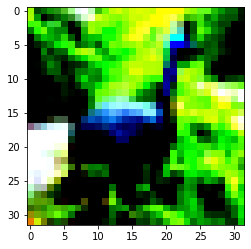

In [ ]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

### The likelihood
Now we can see the output of the model when we use our image rerpresented as a one dimensional vector as input. The model output is called the likelihood of the image to contain an airplane or a bird.

In [ ]:
out = model(img_batch)
out

tensor([[0.5493, 0.4507]], grad_fn=<SoftmaxBackward0>)

In [ ]:
out.sum()

tensor(1., grad_fn=<SumBackward0>)

Our model thinks it's a bird, as it assigns the highest probability to the 2nd vector element, and it's correct but only as a random guess since our model is not trained and its parameters are randomly initialized. We can get the index of the highest probability (argmax) using the max() function

In [ ]:
_, index = torch.max(out, dim=1)

In [ ]:
class_names[index]


'airplane'

### The loss function
So far we have used the mean square error (MSE) for the loss function to be minimized. Now we will use the negative log likelihood (NLL) since it works better for classification tasks than MSE. The negative log likelihood (NLL) returns a lower value when the likelihood is high and a higher value (higher loss) when the likelihood is low. Since the loss function is used for the training we change the output layer to use the logarithm of the softmax in the model instead of just the softmax.

In [ ]:
model = nn.Sequential(
  nn.Linear(num_input_units, num_hidden_units),
  nn.Tanh(),
  nn.Linear(num_hidden_units, n_out),
  nn.LogSoftmax(dim=1))

In [ ]:
loss = nn.NLLLoss()

We compute the output of the model for the same image and the associated loss 

In [ ]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
label, class_names[index], loss(out, torch.tensor([label]))

(1, 'bird', tensor(0.6488, grad_fn=<NllLossBackward0>))

### The DataLoader
Now that the model and the loss function are defined we can use the data to train it. We might set up a training loop for which we update the model parameters with any single image but the procedure will not have any improvement by using a GPU. We can use the PyTorch DataLoader class to create batches of images taken randomly from the dataset. For example we will create batches (tensors) of size 64x3x32x32. This procedure will make use of the GPU and will improve the performance of the training task.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [ ]:
import torch.optim as optim

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100
loss_list = []
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(float(loss))
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.000962
Epoch: 1, Loss: 0.000917
Epoch: 2, Loss: 0.001642
Epoch: 3, Loss: 0.002132
Epoch: 4, Loss: 0.001484
Epoch: 5, Loss: 0.002653
Epoch: 6, Loss: 0.001539
Epoch: 7, Loss: 0.003492
Epoch: 8, Loss: 0.000847
Epoch: 9, Loss: 0.002073
Epoch: 10, Loss: 0.000759
Epoch: 11, Loss: 0.001338
Epoch: 12, Loss: 0.001858
Epoch: 13, Loss: 0.002894
Epoch: 14, Loss: 0.002263
Epoch: 15, Loss: 0.001724
Epoch: 16, Loss: 0.001499
Epoch: 17, Loss: 0.001522
Epoch: 18, Loss: 0.001828
Epoch: 19, Loss: 0.000643
Epoch: 20, Loss: 0.000809
Epoch: 21, Loss: 0.001566
Epoch: 22, Loss: 0.001255
Epoch: 23, Loss: 0.001284
Epoch: 24, Loss: 0.002933
Epoch: 25, Loss: 0.001497
Epoch: 26, Loss: 0.001044
Epoch: 27, Loss: 0.002121
Epoch: 28, Loss: 0.007567
Epoch: 29, Loss: 0.002191
Epoch: 30, Loss: 0.002026
Epoch: 31, Loss: 0.000923
Epoch: 32, Loss: 0.000584
Epoch: 33, Loss: 0.001224
Epoch: 34, Loss: 0.002666
Epoch: 35, Loss: 0.001126
Epoch: 36, Loss: 0.000708
Epoch: 37, Loss: 0.002302
Epoch: 38, Loss: 0.000

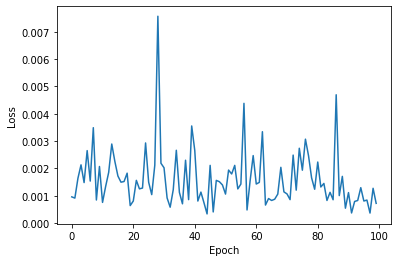

In [ ]:
from matplotlib import pyplot as plt
epochs = range(n_epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss');
plt.plot(epochs, loss_list)

### Accuracy
We can compute the accuracy of the model by counting the number of images in the validation set that are missclassified. 

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
  print("Accuracy: %f"%(correct / total))

Accuracy: 0.815000


### Number of model parameters
We can compute the number of parameters in each layer and so the total number of parameters in our model.

In [ ]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

### Issues with a fully connected neural network
There are two problem in using a fully connected neural network. One problem is that the network does not scale well with the size of the image. The second problem is that the network is not translation invariant: the same object translated in a different position is treated like a different one so the network is less efficient.